In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale

import random
import cv2
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3, ResNet50
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation

In [2]:
label = pd.read_csv('../input/clothing-dataset-full/images.csv')

In [3]:
labels = list(label['label'].unique())

In [4]:
labels

['Not sure',
 'T-Shirt',
 'Shoes',
 'Shorts',
 'Shirt',
 'Pants',
 'Skirt',
 'Other',
 'Top',
 'Outwear',
 'Dress',
 'Body',
 'Longsleeve',
 'Undershirt',
 'Hat',
 'Polo',
 'Blouse',
 'Hoodie',
 'Skip',
 'Blazer']

In [5]:
path = '../input/clothing-dataset-full/images_compressed/'
y = pd.get_dummies(label['label'])
x = pd.DataFrame()
x['image_id'] = label['image'] + '.jpg'
#x['label'] = label['label'] 
x['filepath'] = path+ label['image'] + '.jpg'

In [6]:
file_list = os.listdir('../input/clothing-dataset-full/images_compressed')

In [7]:
x = list(x['filepath'].values)

In [8]:
for idx,tmp in enumerate(x):
    if (tmp in file_list):
        print('False in ' + str(idx))

In [9]:
path = '../input/clothing-dataset-full/images_compressed/'
y = pd.get_dummies(label['label'])
x = pd.DataFrame()
x['image_id'] = label['image'] + '.jpg'
#x['label'] = label['label'] 
x['filepath'] = path+ label['image'] + '.jpg'

In [10]:
x = list(x['filepath'].values)
y = list(y.values)



In [11]:
delete = [533,702,859,1659,1759]
for de in delete:
    del y[de]
    del x[de]
    

In [12]:
# batch_size = 32
# training_data = tf.data.Dataset.from_tensor_slices((x,y))
# #validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))
# def load_image_and_label_from_path(image_path, label):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
#     return img, label


# training_data = training_data.map(load_image_and_label_from_path)
# # training_data_batches = training_data.shuffle(buffer_size=1000).batch(batch_size)

In [13]:
img_size = 224
img_shape = (img_size,img_size,3)
batch_size = 32
epochs = 20
dropout_rate = 0.5
num_of_predict = len(y[0])
len_data = 4000

In [14]:
train_img = []
for idx,img in enumerate(x):
    try:
        tmp = cv2.imread(img
                                    , cv2.IMREAD_COLOR)
        tmp = cv2.resize(tmp,dsize=(img_size,img_size),
                                interpolation=cv2.INTER_AREA)
        train_img.append(tmp)
    except Exception as e:
        print(str(e)+str(idx))
train_img = np.array(train_img)

# delete = [533,702,859,1659,1759]
# for de in delete:
#     del y[de]

In [15]:
# delete = [533,702,859,1659,1759]
# for de in delete:
#     del y[de]

In [16]:
print(len(train_img),len(y))

5398 5398


In [17]:
train_img = np.array(train_img)/255.
y = np.array(y)

In [18]:
train_x = train_img[:4000]
val_x = train_img[4000:]
train_y = y[:4000]
val_y = y[4000:]

In [19]:
del train_img
del y

In [20]:
# ResNet50 = ResNet50(
#         include_top=False, weights='imagenet',
#         input_shape=img_shape, classes=13
#     )

# inputs = Input(shape=img_shape)
# ResNet50 = ResNet50(inputs) 
# pooling = layers.GlobalAveragePooling2D()(ResNet50) 
# dropout = layers.Dropout(dropout_rate)(pooling) #dropout
# outputs = Dense(len(y[0]), activation="softmax")(dropout)
# model = Model(inputs=inputs, outputs=outputs)

In [21]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=img_size, width=img_size),
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [22]:
efficientnet = EfficientNetB3(weights="../input/keras-efficientnetb3-no-top-weights/efficientnetb3_notop.h5",
                              include_top=False, 
                              input_shape=img_shape, 
                              drop_connect_rate=dropout_rate)

inputs = Input(shape=img_shape)
#augmented = data_augmentation_layers(inputs) #Augmentation
efficientnet = efficientnet(inputs) #efficientnet
pooling = layers.GlobalAveragePooling2D()(efficientnet) #globalaveragepooling
dropout = layers.Dropout(dropout_rate)(pooling) #dropout
outputs = Dense(len(val_y[0]), activation="softmax")(dropout)
model2 = Model(inputs=inputs, outputs=outputs)

In [23]:
decay_steps = int(round(4000*0.8/batch_size))*epochs
cosine_decay = CosineDecay(initial_learning_rate=3e-5, decay_steps=decay_steps, alpha=0.3)

model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=["accuracy"])

In [24]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                30740     
Total params: 10,814,275
Trainable params: 10,726,972
Non-trainable params: 87,303
_________________________________________________________________


In [25]:
# history = model2.fit(training_data,batch_size=32,
#                   epochs = 1 )

In [26]:
history = model2.fit(train_x,train_y, batch_size=batch_size,
                   epochs = 25,
                   validation_data=(val_x, val_y))

Epoch 1/25
125/125 [==============================] - 71s 446ms/step - loss: 3.0090 - accuracy: 0.0916 - val_loss: 3.0050 - val_accuracy: 0.0050
Epoch 2/25
125/125 [==============================] - 52s 418ms/step - loss: 2.4288 - accuracy: 0.3581 - val_loss: 2.9355 - val_accuracy: 0.1381
Epoch 3/25
125/125 [==============================] - 52s 417ms/step - loss: 1.9345 - accuracy: 0.4873 - val_loss: 2.4222 - val_accuracy: 0.3748
Epoch 4/25
125/125 [==============================] - 52s 418ms/step - loss: 1.6157 - accuracy: 0.5579 - val_loss: 2.1797 - val_accuracy: 0.4428
Epoch 5/25
125/125 [==============================] - 52s 413ms/step - loss: 1.3637 - accuracy: 0.6389 - val_loss: 1.3846 - val_accuracy: 0.6209
Epoch 6/25
125/125 [==============================] - 52s 416ms/step - loss: 1.2001 - accuracy: 0.6768 - val_loss: 1.0518 - val_accuracy: 0.7003
Epoch 7/25
125/125 [==============================] - 52s 418ms/step - loss: 1.0574 - accuracy: 0.7194 - val_loss: 0.9218 - val_ac

In [27]:
model2.evaluate(x=val_x,y= val_y)

44/44 [==============================] - 3s 73ms/step - loss: 0.6171 - accuracy: 0.8205


[0.617077648639679, 0.8204578161239624]

In [28]:
model2.save('eff_final.h5')

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

image = Image.open(tmp.iloc[0]['filepath'])
plt.imshow(image)
plt.show()

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

<function matplotlib.pyplot.show(close=None, block=None)>

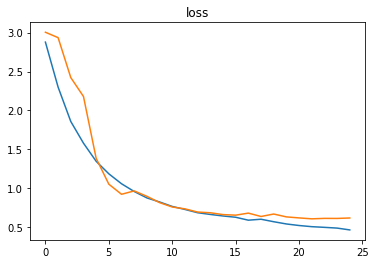

In [30]:
tt =list(range(len(history.history['loss'])))
plt.plot(tt,history.history['loss'])
plt.plot(tt,history.history['val_loss'])
plt.title('loss')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

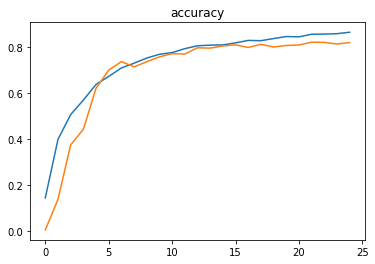

In [31]:
plt.plot(tt,history.history['accuracy'])
plt.plot(tt,history.history['val_accuracy'])
plt.title('accuracy')
plt.show